In [3]:
from pathlib import Path
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

Wrangle top model run ids

In [4]:
top_models = pd.read_csv(Path(filepaths.artifacts) / "250209_top_models.csv", sep=',')
top_models.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,X_d_transform,batch_norm,...,epoch,train_loss,val/accuracy,val/binary_precision,val/binary_recall,val/f1,val/mcc,val/prc,val/roc,val_loss
0,2025-02-07 13:21:04,3.9h,ff90895a6070499b8fdcdc0982526885,dazzling-rat-180,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.025103,0.809866,0.963687,0.631624,0.762649,0.653961,0.921851,0.912527,0.762649
1,2025-02-07 13:20:39,3.1h,8a155bc5673b4c6aa8667dd55755fe0b,zealous-eel-839,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.002602,0.809679,0.972779,0.624411,0.760160,0.656536,0.959718,0.961152,0.760160
2,2025-02-07 13:20:39,3.1h,5ca6ba7b8aec4b81a366e9138b9c09b0,smiling-colt-432,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.004807,0.797277,0.969662,0.600536,0.741214,0.635536,0.947565,0.949833,0.741214
3,2025-02-07 13:20:35,3.4h,2241478505f9497885d25b9a0dee3ffd,fortunate-panda-724,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.027877,0.950560,0.979499,0.919235,0.948325,0.902712,0.986876,0.986808,0.948325
4,2025-02-07 13:20:33,3.4h,e638683b53f84d0ba1c8f32794413e0e,burly-goat-264,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.044305,0.949125,0.977389,0.918329,0.946844,0.899774,0.984206,0.986065,0.946844


In [5]:
outer_run_ids = top_models['Run ID'].to_list()
print(",".join(outer_run_ids))

ff90895a6070499b8fdcdc0982526885,8a155bc5673b4c6aa8667dd55755fe0b,5ca6ba7b8aec4b81a366e9138b9c09b0,2241478505f9497885d25b9a0dee3ffd,e638683b53f84d0ba1c8f32794413e0e,fb3c7a9061a744fba7dabf9d50092414,4bf93c6830744a4b8e6d8076f14a82e1,ef2ce94281fb445ba304791f991e23cc


In [6]:
search_cols = [
    "data/neg_multiple",
    "data/split_strategy",
    "training/pos_multiplier",
    "model/name",
    "model/d_h_encoder",
    "model/encoder_depth",
    "model/radius",
    "model/vec_len",
]

top_models.loc[:, search_cols]

,data/neg_multiple,data/split_strategy,training/pos_multiplier,model/name,model/d_h_encoder,model/encoder_depth,model/radius,model/vec_len
0,3,rcmcs,3,bom,300,6.0,NaN,NaN
1,3,rcmcs,3,rc_agg,300,4.0,NaN,NaN
2,3,rcmcs,3,rc_cxn,300,6.0,NaN,NaN
3,3,homology,3,rc_cxn,300,6.0,NaN,NaN
4,3,homology,3,rc_agg,300,4.0,NaN,NaN
5,3,rcmcs,3,mfp,300,NaN,2.0,2048.0
6,3,homology,3,mfp,300,NaN,2.0,2048.0
7,3,homology,3,bom,300,6.0,NaN,NaN


In [ ]:
split_runs = {}
for i, row in top_models.iterrows():
    conditions = ["params.'data/split_idx' >= '0'"]
    for col in search_cols:
        val = row[col]

        if pd.isna(val):
            continue
        
        if isinstance(val, float) and val % 1 == 0:
            val = int(val)

        conditions.append(f"params.'{col}' = '{val}'")

    filter_string = " AND ".join(conditions)
    split_runs[row['Run ID']] = mlflow.search_runs(filter_string=filter_string)

In [8]:
inner_runs = pd.concat(split_runs.values())
inner_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val/roc,metrics.val/prc,metrics.train_loss,metrics.val_loss,...,params.max_lr,params.data/toc,params.final_lr,params.data/dataset,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,params.model/radius,params.model/vec_len
0,af1e9fbcef4546e689652a15ef6123ff,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-03 10:48:14.384000+00:00,2025-02-04 08:33:09.719000+00:00,0.958550,0.958709,0.000853,0.857535,...,0.001,v3_folded_pt_ns,0.0001,sprhea,spn1560,LOCAL,grandiose-robin-923,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,NaN,NaN
1,eb05684d7fd846eaa95654c7814abd40,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-03 10:10:25.056000+00:00,2025-02-04 10:21:46.689000+00:00,0.946668,0.949820,0.053555,0.789959,...,0.001,v3_folded_pt_ns,0.0001,sprhea,spn1560,LOCAL,gaudy-mule-125,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,NaN,NaN
2,e2c936866af944a1aaa3e73380d2c072,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-03 09:29:31.200000+00:00,2025-02-04 13:07:34.342000+00:00,0.942648,0.942115,0.030115,0.733743,...,0.001,v3_folded_pt_ns,0.0001,sprhea,spn1560,LOCAL,mysterious-fawn-710,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,NaN,NaN
0,db987cbcf4c6492b90fd2f1adab33b96,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-01 02:06:29.565000+00:00,2025-02-01 13:56:03.526000+00:00,0.957237,0.957447,0.000995,0.806823,...,0.001,v3_folded_pt_ns,0.0001,sprhea,spn1560,LOCAL,silent-seal-423,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,NaN,NaN
1,04b0957ef18f4ed69ce0f114702c8f00,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-01 01:46:49.096000+00:00,2025-02-02 05:38:13.628000+00:00,0.948078,0.949877,0.005608,0.799070,...,0.001,v3_folded_pt_ns,0.0001,sprhea,spn1560,LOCAL,valuable-chimp-577,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,NaN,NaN


In [9]:
run_ids = top_models['Run ID'].to_list() + inner_runs['run_id'].to_list()
print(",".join(run_ids))
print(len(run_ids))

ff90895a6070499b8fdcdc0982526885,8a155bc5673b4c6aa8667dd55755fe0b,5ca6ba7b8aec4b81a366e9138b9c09b0,2241478505f9497885d25b9a0dee3ffd,e638683b53f84d0ba1c8f32794413e0e,fb3c7a9061a744fba7dabf9d50092414,4bf93c6830744a4b8e6d8076f14a82e1,ef2ce94281fb445ba304791f991e23cc,af1e9fbcef4546e689652a15ef6123ff,eb05684d7fd846eaa95654c7814abd40,e2c936866af944a1aaa3e73380d2c072,db987cbcf4c6492b90fd2f1adab33b96,04b0957ef18f4ed69ce0f114702c8f00,95963b479bb9434ba0c4fb43a05dc7a4,62d84f7e370843489adab8c62efa74ab,3d93a80556ae4538951ea0122c48bb84,4cddcf9c4aa4439a989a5832a3df20de,74c15732aa1747b09eef3f3a67826260,4b80162c6a6849b1ace18e889cfbe571,d320827e0c754801b76edf5efe82d8f9,25aaed1cb3b04b028724c775048c9f39,9c3608ffe8dd439598958350a2cb9fb2,6d850586e6674fd2b4eb520b1d3b7494,c749ed3999f4408aa8e39d0ec4e7ff4a,62491f3e711e4d8b8bbe2ac27c85c4db,e38a5553209a4d5c8063f0e2abb54d74,bc114570a3a24a6e8384666ba854d320,96036ba3999d437fb79560ec4b0e5f88,a785183783074fee877eb15f7bb2a337,81b9c114084446338974bcda6b36c4dc,47547b9e0b

Tune threshold

In [10]:
thresholds = np.linspace(0, 1, num=100)
best_thresholds = {}
best_inner_f1s = {}
for oid, df in zip(outer_run_ids, split_runs.values()):
    thresh_f1s = []
    y_logits = []
    for inner_id in df['run_id']:
        target_output_path = Path(filepaths.results) / 'predictions' / inner_id / 'target_output.parquet'
        target_output = pd.read_parquet(target_output_path)
        y_logits.append((target_output['y'], target_output['logits']))

    best_th = thresholds[0]
    best_f1 = 0
    for th in thresholds:

        # Get f1 for each split
        f1s = []
        for y, logits in y_logits:
            ypred = (logits > th).astype(np.int32)
            f1 = f1_score(y_true=y, y_pred=ypred, average='binary')
            f1s.append(f1)

        mean_f1 = sum(f1s) / len(f1s)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_th = th

    best_thresholds[oid] = best_th
    best_inner_f1s[oid] = best_f1

In [11]:
best_thresholds

{'ff90895a6070499b8fdcdc0982526885': 0.010101010101010102,
 '8a155bc5673b4c6aa8667dd55755fe0b': 0.010101010101010102,
 '5ca6ba7b8aec4b81a366e9138b9c09b0': 0.010101010101010102,
 '2241478505f9497885d25b9a0dee3ffd': 0.15151515151515152,
 'e638683b53f84d0ba1c8f32794413e0e': 0.12121212121212122,
 'fb3c7a9061a744fba7dabf9d50092414': 0.010101010101010102,
 '4bf93c6830744a4b8e6d8076f14a82e1': 0.05050505050505051,
 'ef2ce94281fb445ba304791f991e23cc': 0.26262626262626265}

In [12]:
preds = {}
for id in run_ids:
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output

In [14]:
# Style

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "mfp": "Morgan fingerprint",
}

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "mfp": "black",
}

metrics = {
    'val/f1': f1_score,
    'val/binary_precision': precision_score,
    'val/binary_recall': recall_score,
    'val/accuracy': accuracy_score
}

metric_names = {
    'val/f1': "F1",
    'val/binary_precision': "Precision",
    'val/binary_recall': "Recall",
    'val/accuracy': "Accuracy",
}

split_strategies = [
    'rcmcs',
    'homology',
]


PRC and ROC curves

rcmcs


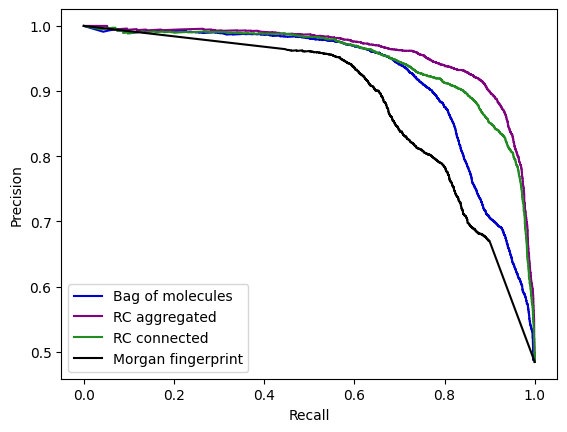

homology


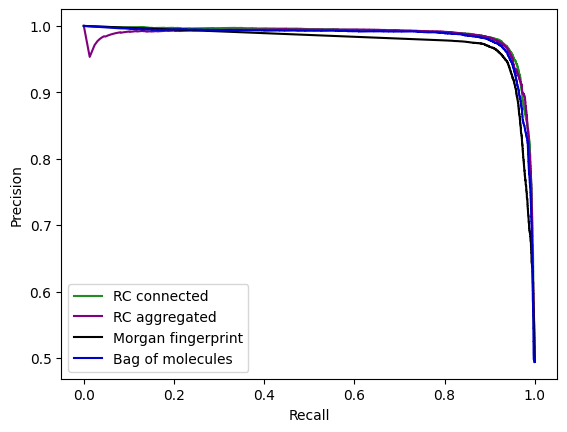

In [15]:
# PRC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        ax.plot(recall, prec, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    plt.show()



rcmcs


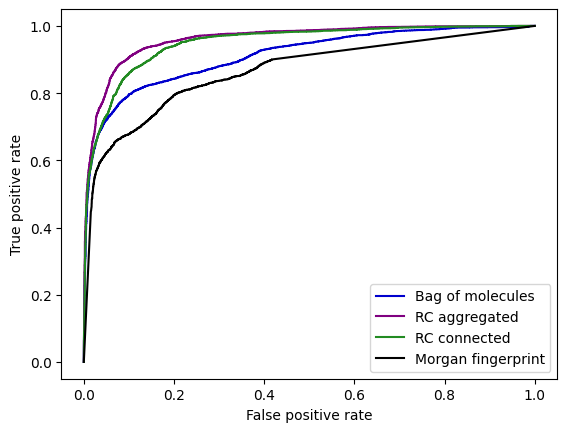

homology


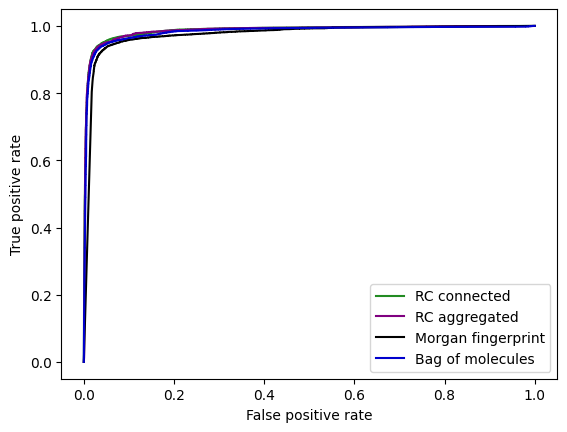

In [16]:
# ROC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        ax.plot(fpr, tpr, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.legend()
    plt.show()

Top models inner val metrics with test overlay

In [ ]:
# Bar chart constants

x = {mn: i for i, mn in enumerate(labels)}
figsize = (13, 3)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

rcmcs


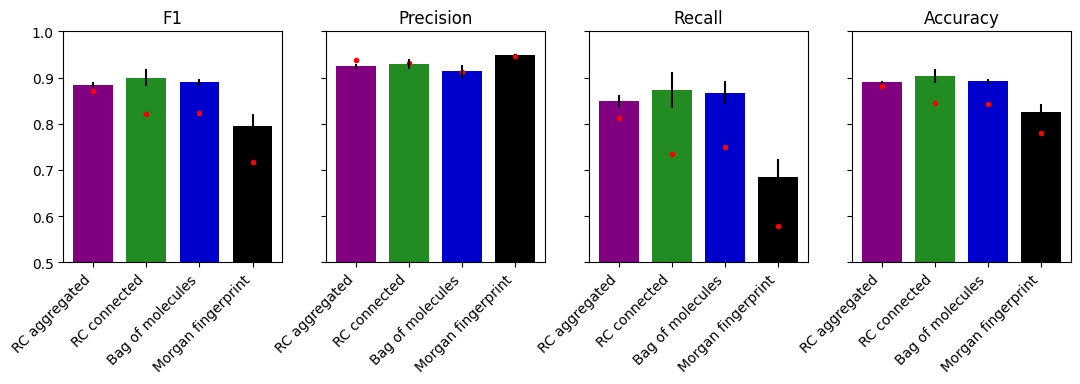

homology


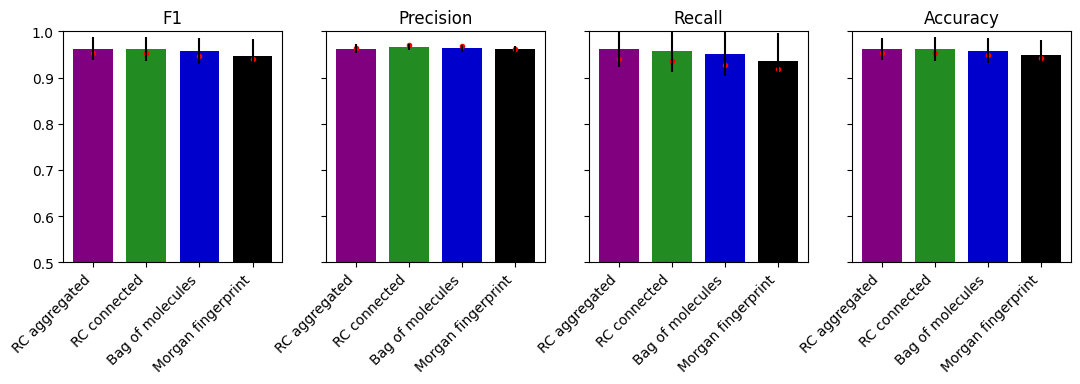

In [ ]:
for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=True)
    for j, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
        model_name = row['model/name']
        oid = row['Run ID']
        th = best_thresholds[oid]
        inner_folds = split_runs[oid]
        outer_pred = preds[oid]
        outer_y = outer_pred['y']
        outer_ypred = (outer_pred['logits'] > th).astype(int)
        for i, (metric_k, metric) in enumerate(metrics.items()):
            outer_metric = metric(outer_y, outer_ypred)
            ax[i].plot(x[model_name], outer_metric, 'r.')

            inner_metrics = []
            for iid in inner_folds.loc[:, 'run_id']:
                pred = preds[iid]
                ypred = (pred['logits'] > th).astype(int)
                inner_metrics.append(metric(pred['y'], ypred))
            
            inner_metrics = np.array(inner_metrics)
            ax[i].bar(x=x[model_name], height=inner_metrics.mean(), width=width, yerr=inner_metrics.std(), color=colors[model_name])
            ax[i].set_xticks(list(x.values()))
            ax[i].set_xticklabels(list(labels.values()), rotation=xtick_rot, ha=xtick_ha)
            ax[i].set_title(metric_names[metric_k])
            ax[i].set_ylim(*ylim)

    plt.show()
            

Performance broken down by similarity bucket

In [19]:
sim_path = Path(filepaths.results) / 'similarity_matrices'
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

S_rcmcs = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='rcmcs'
)

S_gsi = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='gsi'
)

In [20]:
rcmcs_eg = top_models.loc[top_models['data/split_strategy'] == 'rcmcs', 'Run ID'].iloc[0]
gsi_eg = top_models.loc[top_models['data/split_strategy'] == 'homology', 'Run ID'].iloc[0]
val_pidx = preds[gsi_eg].loc[:, 'protein_idx'].to_list()
train_pidx = [i for i in range(S_gsi.shape[0]) if i not in val_pidx]
val_ridx = preds[rcmcs_eg].loc[:, 'reaction_idx'].to_list()
train_ridx = [i for i in range(S_rcmcs.shape[0]) if i not in val_ridx]
max_rcmcs_sims = S_rcmcs[:, val_ridx][train_ridx].max(axis=0)
max_gsi_sims = S_gsi[:, val_pidx][train_pidx].max(axis=0)

for oid in outer_run_ids:
    if len(preds[oid]) == len(max_rcmcs_sims):
        preds[oid]['max_rcmcs'] = max_rcmcs_sims
    elif len(preds[oid]) == len(max_gsi_sims):
        preds[oid]['max_gsi'] = max_gsi_sims

In [49]:
# Clustered bar chart constants

bins = [
    (0.8, 1),
    (0.6, 0.8),
    (0.4, 0.6),
    (0.0, 0.4),
]

bin_labels = [
    "[0.8, 1.0)",
    "[0.6, 0.8)",
    "[0.4, 0.6)",
    "[0.0, 0.4)"
]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.2
space = 1.01
offset = (len(labels) / 2) * width
x = [i for i in range(len(bins))]
figsize = (15, 4)
ylim = (0.2, 1.0)

rcmcs
val/f1


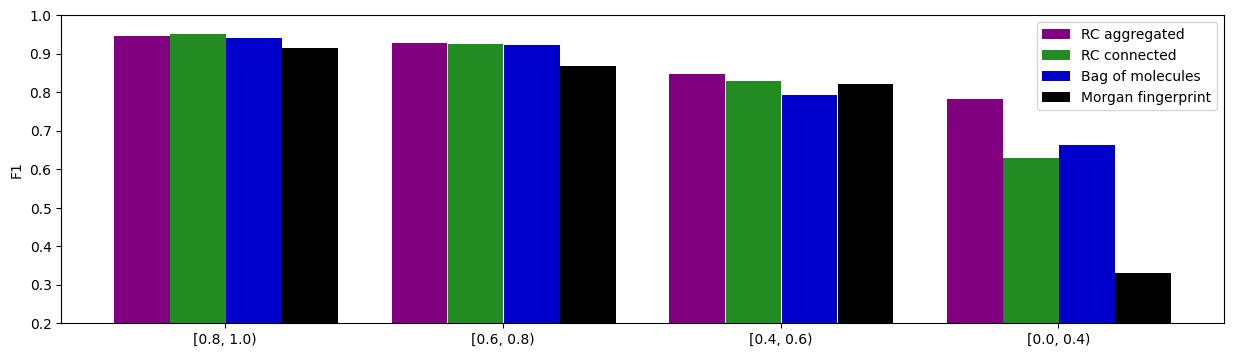

val/binary_precision


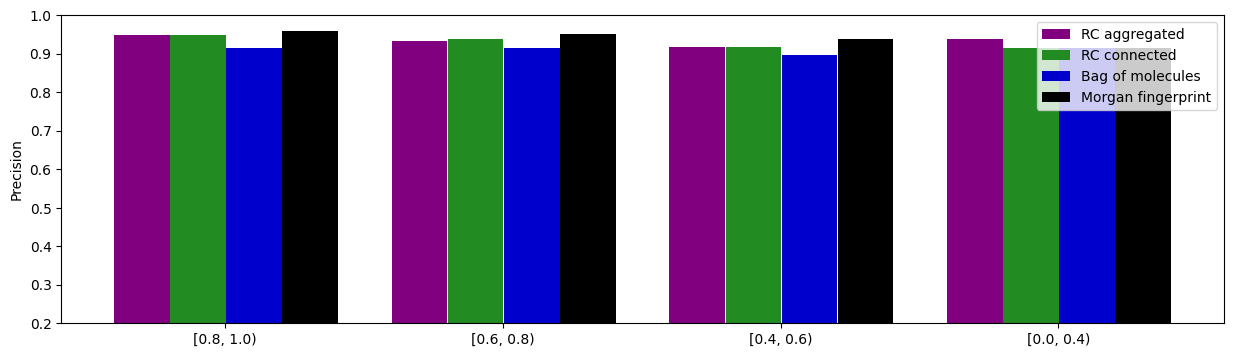

val/binary_recall


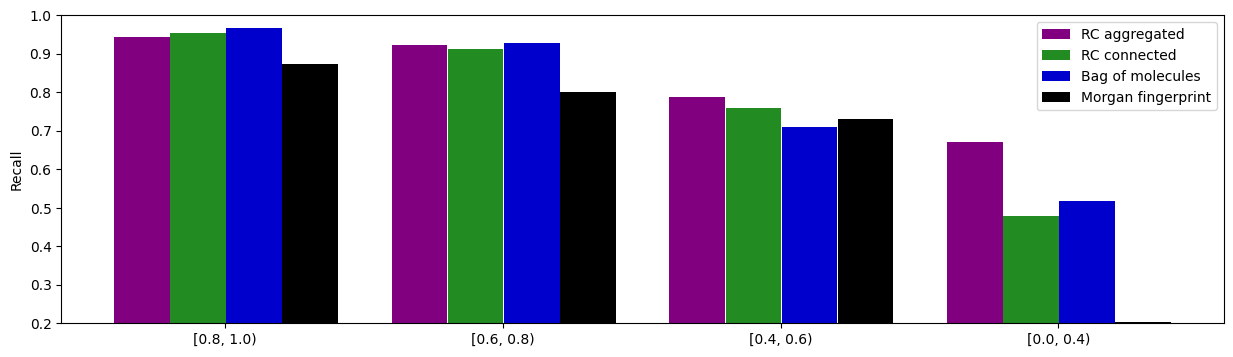

val/accuracy


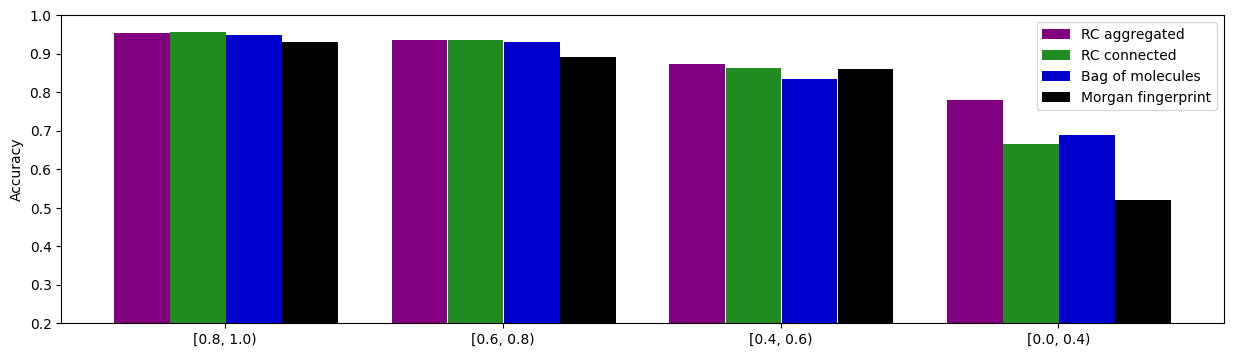

homology
val/f1


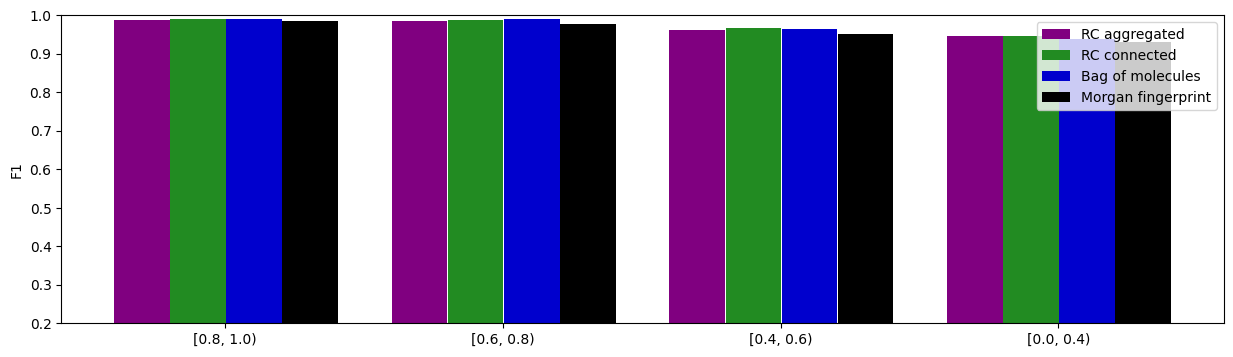

val/binary_precision


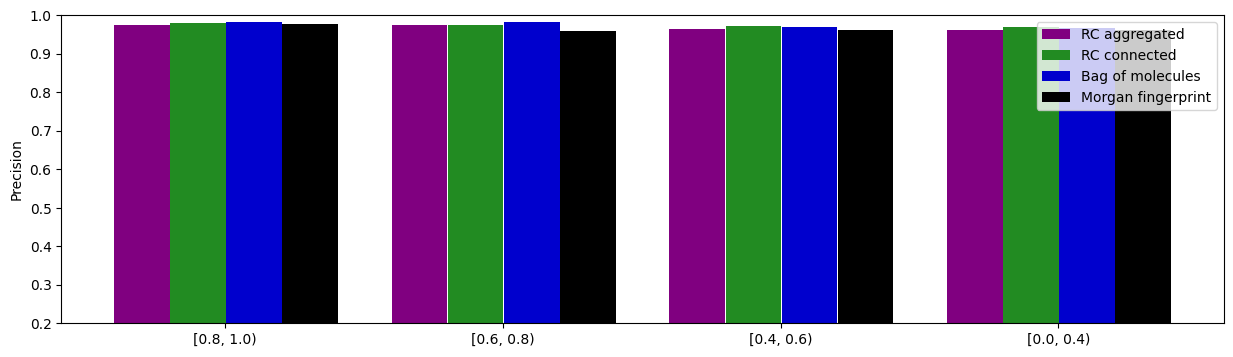

val/binary_recall


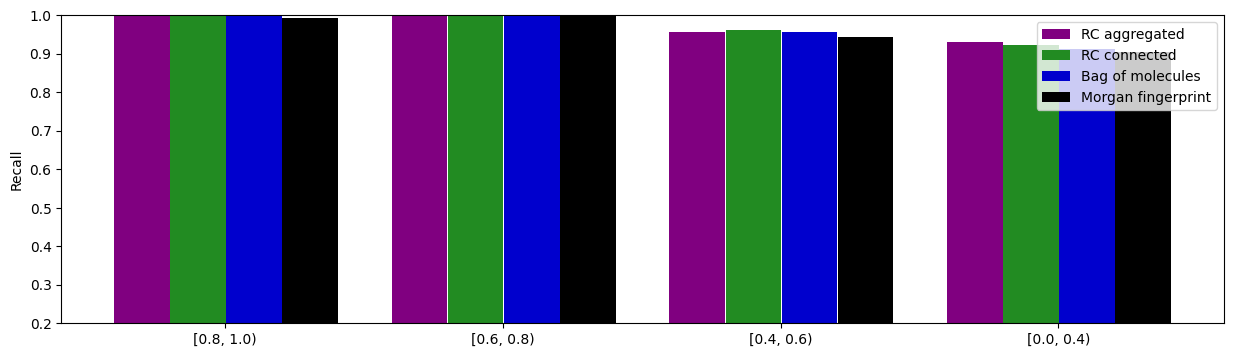

val/accuracy


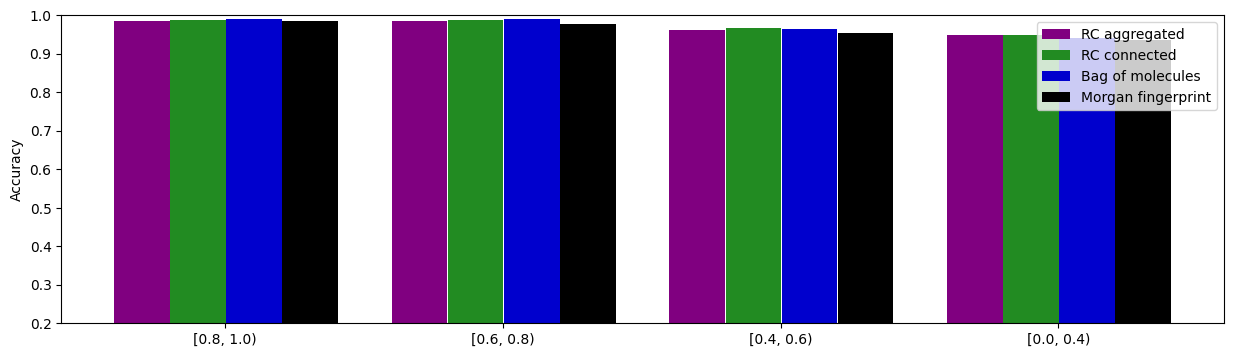

In [52]:
for strat in split_strategies:
    print(strat)
    for metric_k, metric in metrics.items():
        print(metric_k)
        fig, ax = plt.subplots(figsize=figsize, sharey=True)
        for i, (lb, ub) in enumerate(bins):
            for _, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
                model_name = row['model/name']
                oid = row['Run ID']
                th = best_thresholds[oid]
                pred = preds[oid]

                if strat == 'rcmcs':
                    pred = pred.loc[(pred['max_rcmcs'] < ub) & (pred['max_rcmcs'] >= lb)]
                elif strat == 'homology':
                    pred = pred.loc[(pred['max_gsi'] < ub) & (pred['max_gsi'] >= lb)]
                
                ypred = (pred['logits'] > th).astype(int)
                metric_val = metric(pred['y'], ypred)

                ax.bar(x=x[i] - offset + width * bar_shifts[model_name] * space, height=metric_val, width=width, color=colors[model_name])
            
        for key in labels:
            ax.bar(0, 0, color=colors[key], label=labels[key])
        
        ax.set_ylim(*ylim)
        ax.set_xticks(np.array(x) - width / 2)
        ax.set_xticklabels(bin_labels)
        ax.set_ylabel(metric_names[metric_k])
        ax.legend(loc='upper right')
        plt.show()

In [65]:
# Split count bar constants

width = 0.5

x = [i for i in range(len(bins))]
figsize = (6, 4)
ylim = (0.0, 1.0)

rcmcs


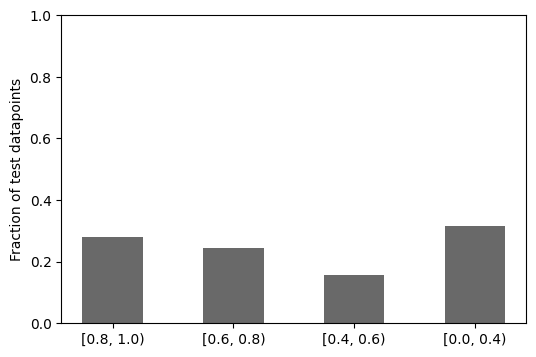

homology


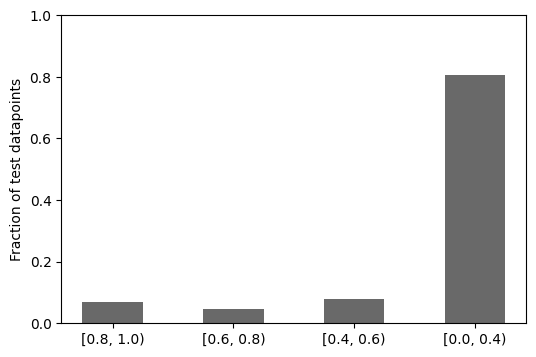

In [68]:
# Background split counts

for strat, eg_id in zip(split_strategies, [rcmcs_eg, gsi_eg]):
    print(strat)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    for i, (lb, ub) in enumerate(bins):
        pred = preds[eg_id]
        n_tot = len(pred)

        if strat == 'rcmcs':
            n_bucket = len(pred.loc[(pred['max_rcmcs'] < ub) & (pred['max_rcmcs'] >= lb)])
        elif strat == 'homology':
            n_bucket = len(pred.loc[(pred['max_gsi'] < ub) & (pred['max_gsi'] >= lb)])

        ax.bar(x=x[i], height=n_bucket / n_tot, width=width, color="dimgray")
    
    ax.set_ylim(*ylim)
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels)
    ax.set_ylabel("Fraction of test datapoints")
    plt.show()

In [70]:
# Background hist constants

nbins = 20
figsize = (6, 4)

rcmcs


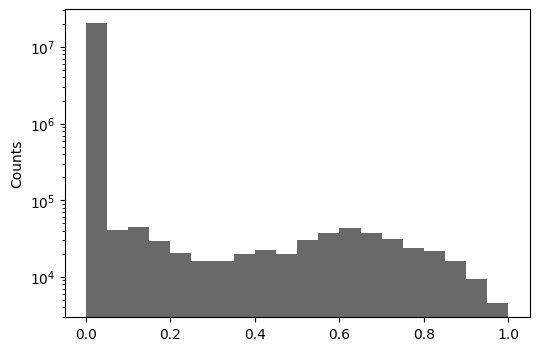

homology


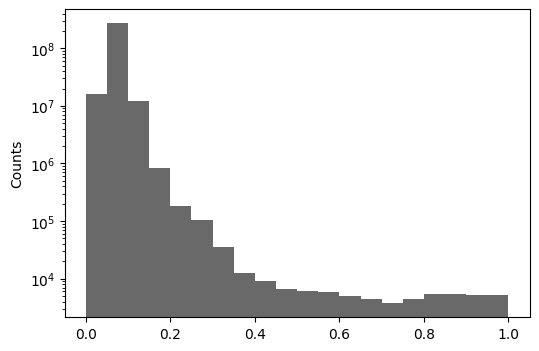

In [82]:
# Background max sim distribution

for strat, eg_id in zip(split_strategies, [rcmcs_eg, gsi_eg]):
    print(strat)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    pred = preds[eg_id]

    if strat == 'rcmcs':
        sims = S_rcmcs[np.triu_indices_from(S_rcmcs, k=1)]
        # sims = pred['max_rcmcs'].to_list()
    elif strat == 'homology':
        sims = S_gsi[np.triu_indices_from(S_gsi, k=1)]
        # sims = pred["max_gsi"].to_list()

    ax.hist(sims, bins=nbins, color="dimgray")
    ax.set_ylabel("Counts")
    ax.set_yscale('log')
    plt.show()